In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [2]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
call = pd.read_csv('feb16-mar15_data/call/older/call_data_week_1.csv', sep='\t')


In [3]:
df

,Unnamed: 0,user_id,cluster,arm,registration_date,intervention_week,week1_whittle,after_intervention_E/C,week12_whittle,week0_E/C,...,week2_E/C,week3_E/C,week4_E/C,week5_E/C,week6_E/C,week7_E/C,week8_E/C,week9_E/C,week10_E/C,week11_E/C
0,0,2394384,29,rmab,1144.0,week1,0.865692,20/20,-0.387939,0/2,...,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2
1,80,2396341,29,round_robin,1149.0,week11,0.865692,0/0,0.000000,0/0,...,0/0,0/1,1/1,0/0,0/1,1/1,0/1,1/1,0/1,0/0
2,102,2395407,29,rmab,1152.0,week11,0.865692,0/0,0.000000,0/0,...,0/0,0/1,1/1,1/1,0/1,0/0,1/1,0/0,0/0,0/1
3,103,2405773,29,rmab,1164.0,week1,0.865692,0/0,0.865692,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,104,2391765,29,control,1138.0,NaN,0.865692,0/0,-0.387939,0/2,...,1/2,0/2,0/2,0/2,0/2,1/2,0/2,2/2,1/2,1/2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,22973,2402502,34,rmab,1151.0,NaN,-0.882812,0/0,-0.882812,0/1,...,0/0,0/2,0/1,2/2,1/2,1/2,1/1,1/1,0/1,0/1
22999,22972,2391003,34,round_robin,1124.0,week1,-0.882812,0/9,-0.882812,0/2,...,0/1,0/2,0/1,0/2,0/2,0/1,0/0,0/0,0/0,0/0
23000,22971,2390953,34,control,1136.0,NaN,-0.882812,0/0,-0.882812,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
23001,22970,2385630,34,control,1142.0,NaN,-0.882812,0/0,-0.882812,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [4]:
interv_df = pd.DataFrame(columns=['user_id', 'intervene_week', 'intervene_date', 'exp_group'])
interv_calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721']

from datetime import datetime
week_date_lookup = {f.split('_')[1]:datetime.strptime(f.split('_')[-1], '%d%m%y') for f in interv_calling_files}

for file in interv_calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            interv_week = file.split('_')[1]
            exp_group = df[df['user_id']==user_id]['arm'].iloc[0]
            intervene_date = week_date_lookup[interv_week]
            interv_df = interv_df.append({'user_id': user_id, 'intervene_week': interv_week, 'intervene_date':intervene_date, 'exp_group': exp_group}, ignore_index=True)
interv_df = pd.merge(interv_df, reg[['user_id', 'registration_date']])  
interv_df = pd.merge(interv_df, df[['user_id', 'cluster']])
interv_df['registration_date'] = pd.to_datetime(interv_df['registration_date'])

In [5]:
interv_df['days_since_reg'] = (interv_df['intervene_date'] - interv_df['registration_date']).dt.days
display(interv_df)
display(interv_df.groupby(['intervene_week', 'exp_group']).count())

,user_id,intervene_week,intervene_date,exp_group,registration_date,cluster,days_since_reg
0,2393699,week1,2021-04-29,rmab,2021-02-25,1,63
1,2387277,week1,2021-04-29,round_robin,2021-02-01,10,87
2,2401025,week1,2021-04-29,rmab,2021-03-03,1,57
3,2401025,week3,2021-05-12,rmab,2021-03-03,1,70
4,2401025,week4,2021-05-18,rmab,2021-03-03,1,76
...,...,...,...,...,...,...,...
7180,2395228,week11,2021-07-05,round_robin,2021-02-22,16,133
7181,2395195,week11,2021-07-05,round_robin,2021-02-23,35,132
7182,2392191,week11,2021-07-05,round_robin,2021-02-22,16,133
7183,2394510,week11,2021-07-05,round_robin,2021-02-23,35,132


user_id  intervene_date  registration_date  \
intervene_week exp_group                                                 
week1          rmab             125             125                125   
               round_robin      125             125                125   
week10         rmab             500             500                500   
               round_robin      500             500                500   
week11         rmab             500             500                500   
               round_robin      500             500                500   
week2          rmab             200             200                200   
               round_robin      200             200                200   
week3          rmab             200             200                200   
               round_robin      200             200                200   
week4          rmab             200             200                200   
               round_robin      200             200                200   
week5          rmab             235             235                235   
               round_robin      200             200                200   
week6          rmab             300             300                300   
               round_robin      300             300                300   
week7          rmab             350             350                350   
               round_robin      350             350                350   
week8          rmab             500             500                500   
               round_robin      500             500                500   
week9          rmab             500             500                500   
               round_robin      500             500                500   

                            cluster  days_since_reg  
intervene_week exp_group                             
week1          rmab             125             125  
               round_robin      125             125  
week10         rmab             500             500  
               round_robin      500             500  
week11         rmab             500             500  
               round_robin      500             500  
week2          rmab             200             200  
               round_robin      200             200  
week3          rmab             200             200  
               round_robin      200             200  
week4          rmab             200             200  
               round_robin      200             200  
week5          rmab             235             235  
               round_robin      200             200  
week6          rmab             300             300  
               round_robin      300             300  
week7          rmab             350             350  
               round_robin      350             350  
week8          rmab             500             500  
               round_robin      500             500  
week9          rmab             500             500  
               round_robin      500             500

In [8]:
interv_df.drop(columns=['registration_date']).to_csv('outputs/interventions.csv')

# Load transition prob and starting states


In [7]:
import numpy as np
import pandas as pd
import ipdb
import pickle
from tqdm import tqdm

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

CONFIG = {
    'pilot_data': 'feb16-mar15_data',
    'current_week': 12,
    'calling_files': ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721'],
    'pilot_dates' : ['2021-04-26', '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-07', '2021-06-14', '2021-06-21', '2021-06-28', '2021-07-05', '2021-07-12']
}

assert len(CONFIG['calling_files']) == CONFIG['current_week'] - 1
assert len(CONFIG['pilot_dates']) == CONFIG['current_week']

pilot_beneficiary_data, pilot_call_data = load_data(CONFIG['pilot_data'])
pilot_call_data = _preprocess_call_data(pilot_call_data)

complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

arm_dict = {}
for user_id in rmab_user_ids:
    arm_dict[user_id] = 'rmab'
for user_id in round_robin_user_ids:
    arm_dict[user_id] = 'round_robin'

with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()




2021-09-06 12:52:57,582 - INFO - _init_num_threads - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-09-06 12:52:57,583 - INFO - _init_num_threads - NumExpr defaulting to 8 threads.
2021-09-06 12:53:01,606 - DEBUG - <module> - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2021-09-06 12:53:01,960 - DEBUG - <module> - Creating converter from 7 to 5
2021-09-06 12:53:01,960 - DEBUG - <module> - Creating converter from 5 to 7
2021-09-06 12:53:01,961 - DEBUG - <module> - Creating converter from 7 to 5
2021-09-06 12:53:01,962 - DEBUG - <module> - Creating converter from 5 to 7
2021-09-06 12:53:02,921 - INFO - load_data - Loading data from folder 'feb16-mar15_data'
2021-09-06 12:53:02,932 - INFO - load_call_data - Found 1 files in 'feb16-mar15_data/call'.
2021-09-06 12:53:02,932 - INFO - load_call_data - Loading and cleaning call data.
100%|██████████| 1/1 [00:

2021-09-06 12:53:18,184 - WARNING - gest_age_to_list - introivr is not a valid gestation age.


2021-09-06 12:53:18,538 - INFO - load_call_data - Call data contains 842588 relevant call records for 23516 beneficiaries.
2021-09-06 12:53:18,557 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2021-09-06 12:53:18,558 - INFO - load_data - Beneficiary data contains data for 23516 beneficiaries
2021-09-06 12:53:18,566 - INFO - load_data - Call data contains 842588 call records for 23516 beneficiaries
/Users/vermashresth/Documents/armman-pipeline-latest/training/dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["duration"] = data["duration"].astype('uint8')
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifi

In [8]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

cluster_transition_probabilities

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.666667,0.333333,0.466667,0.533333,0.153001,0.846999,0.258012,0.741988
1,1.0,83.0,0.600000,0.400000,0.875000,0.125000,0.689132,0.310868,0.294719,0.705281
2,2.0,104.0,0.600000,0.400000,0.631579,0.368421,0.560425,0.439575,0.441054,0.558946
3,3.0,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
4,4.0,129.0,0.333333,0.666667,0.176471,0.823529,0.501182,0.498818,0.048505,0.951495
5,5.0,50.0,0.958333,0.041667,0.985655,0.014345,0.818342,0.181658,0.795455,0.204545
6,6.0,128.0,0.571429,0.428571,0.428571,0.571429,0.419136,0.580864,0.263838,0.736162
7,7.0,53.0,0.947368,0.052632,0.479162,0.520838,0.914069,0.085931,0.288961,0.711039
8,8.0,75.0,0.636364,0.363636,0.545455,0.454545,0.390496,0.609504,0.493551,0.506449
9,9.0,117.0,0.402725,0.597275,0.277778,0.722222,0.250526,0.749474,0.108681,0.891319


In [9]:
full_intervention_dict = []
full_intervention_dict.append({})
for idx in range(len(CONFIG['calling_files'])):
    intervention_dict = {}
    for idx2, file in enumerate(CONFIG['calling_files'][:idx+1]):
        
        with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
            for line in fr:
                user_id = int(line.strip())
                if user_id not in intervention_dict:
                    intervention_dict[user_id] = [file.split('_')[1]]
                else:
                    intervention_dict[user_id].append(file.split('_')[1])
    full_intervention_dict.append(intervention_dict)

In [56]:

# ipdb.set_trace()

out_dict = {'user_id': [], 'cluster': [], 'arm': [], 'registration_date': [],
            'intervention_week': [], 'week1_whittle': [], 'after_intervention_E/C' : []}

for i in range(CONFIG['current_week']):
    out_dict['week{}_E/C'.format(i)] = []
    out_dict['week{}_state'.format(i)] = []
    out_dict['week{}_whittle'.format(i)] = []

for user_id in tqdm(all_user_ids):
    out_dict['user_id'].append(user_id)
    curr_row = complete_group[complete_group['user_id'] == user_id]
    curr_cluster = curr_row['cluster'].item()
    out_dict['cluster'].append(curr_cluster)
    out_dict['registration_date'].append(curr_row['registration_date'].item())
    if user_id in arm_dict:
        out_dict['arm'].append(arm_dict[user_id])
    else:
        out_dict['arm'].append('control')

    if user_id in intervention_dict:
        out_dict['intervention_week'].append(intervention_dict[user_id][-1])
    else:
        out_dict['intervention_week'].append('')

    curr_state = None
    countc, counte = 0, 0
    for i, date_val in enumerate(CONFIG['pilot_dates']):
        pilot_date_num = (pd.to_datetime(date_val, format="%Y-%m-%d") - pd.to_datetime("2018-01-01", format="%Y-%m-%d")).days
        
        past_days_calls = pilot_call_data[
            (pilot_call_data["user_id"]==user_id)&
            (pilot_call_data["startdate"]<pilot_date_num)&
            (pilot_call_data["startdate"]>=pilot_date_num - 7)
        ]

        past_days_connections = past_days_calls[past_days_calls['duration']>0].shape[0]
        past_days_engagements = past_days_calls[past_days_calls['duration'] >= 30].shape[0]

        if past_days_engagements == 0:
            curr_state = 7
        else:
            curr_state = 6
        
        if user_id in full_intervention_dict[i] and int(full_intervention_dict[i][user_id][-1][4:]) > i+1 - 4:
            curr_state -= 6
        
        if len(out_dict['intervention_week'][-1]) > 0 and i > int(out_dict['intervention_week'][-1][4:]):
            countc += past_days_connections
            counte += past_days_engagements
        
        out_dict['week{}_E/C'.format(i)].append('{}/{}'.format(past_days_engagements, past_days_connections))
        out_dict['week{}_state'.format(i)].append(curr_state)
        out_dict['week{}_whittle'.format(i)].append(m_values[curr_cluster, curr_state])

    
    
    
    out_dict['after_intervention_E/C'].append('{}/{}'.format(counte, countc))
    out_dict['week0_whittle'].append(curr_row['whittle_index'].item())

analysis_df = pd.DataFrame(out_dict)
analysis_df = df.sort_values('week0_whittle', ascending=False)

In [44]:
# analysis_df = pd.DataFrame(out_dict)

# analysis_df.to_csv('outputs/state-cluster-whittle-E_C.csv')

In [10]:
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')

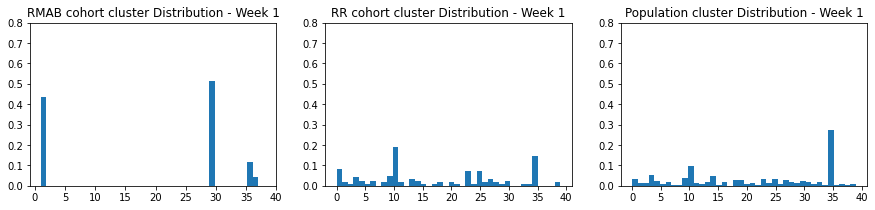

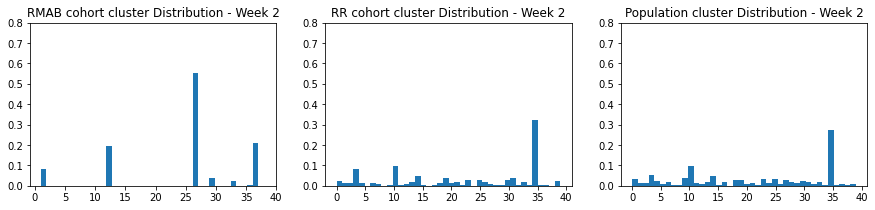

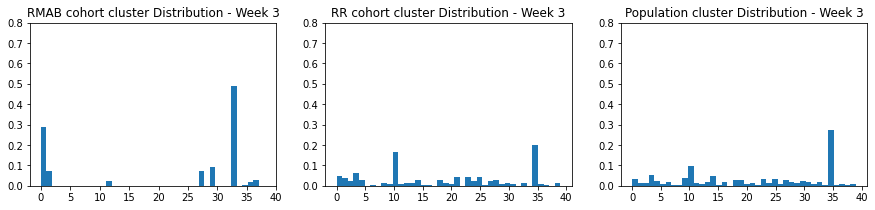

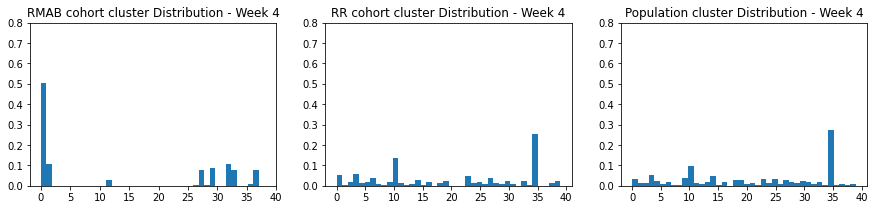

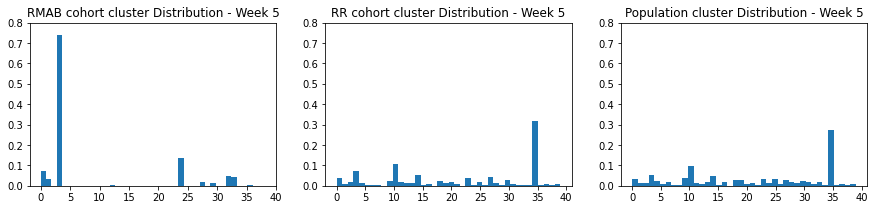

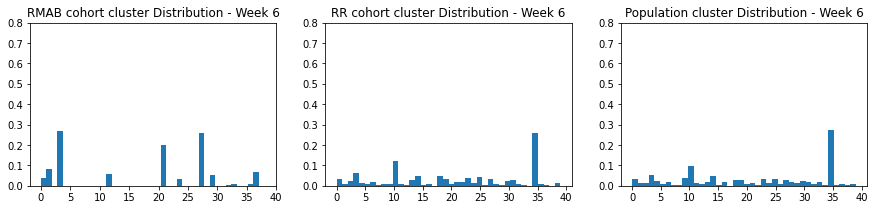

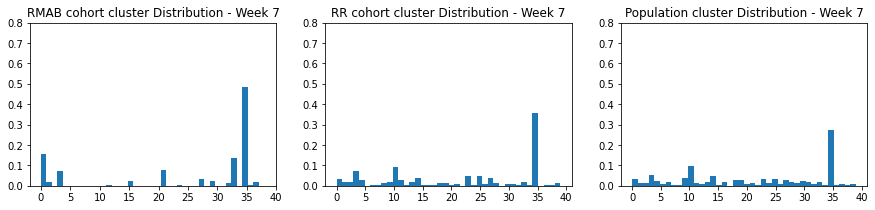

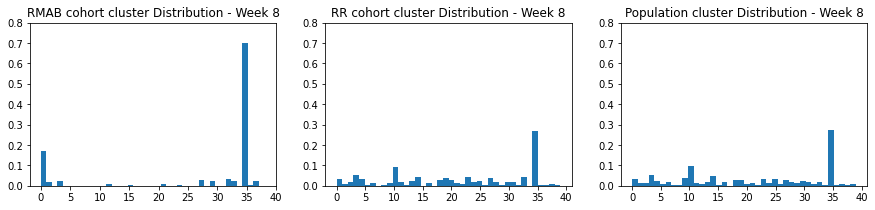

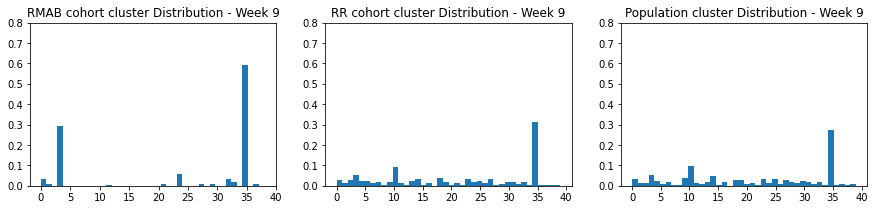

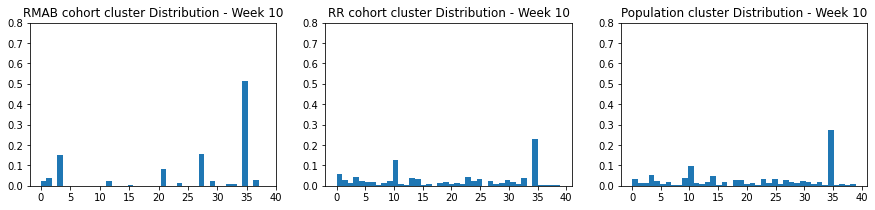

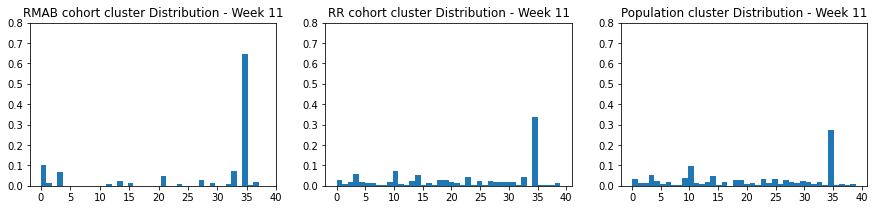

In [74]:
for i in range(T-1):
    plt.figure(figsize=(15, 3))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    plt.subplot(1,3,1)
    plt.hist(sub[sub['exp_group']=='rmab']['cluster'].values,density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RMAB cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,2)
    plt.hist(sub[sub['exp_group']=='round_robin']['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RR cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,3)
    plt.hist(analysis_df['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'Population cluster Distribution - Week {i+1}')

    

In [11]:
lookup = {7:'NE', 6:'E', 0:'Sleep_E', 1:'Sleep_NE'}

def dist_stat(df, col):
    new_df = pd.DataFrame({'Proportion':df[col].value_counts(normalize=True),
                         'Count':df[col].value_counts()})
    new_df.index = pd.Series(new_df.index).replace(lookup)
    cols = np.sort(new_df.index)
    return new_df.loc[cols]

Week0
rmab
    Proportion  Count
E     0.465702   3571
NE    0.534298   4097

RR
    Proportion  Count
E     0.475613   3647
NE    0.524387   4021

All
    Proportion  Count
E     0.477501   3661
NE    0.522499   4006


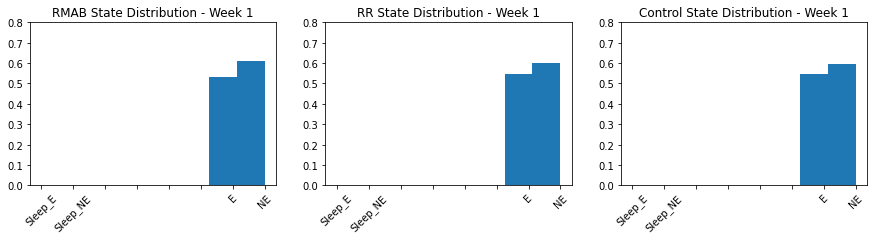




Week1
rmab
          Proportion  Count
E           0.459572   3524
NE          0.524126   4019
Sleep_E     0.002999     23
Sleep_NE    0.013302    102

RR
          Proportion  Count
E           0.453312   3476
NE          0.530386   4067
Sleep_E     0.005999     46
Sleep_NE    0.010303     79

All
    Proportion  Count
E     0.462632   3547
NE    0.537368   4120


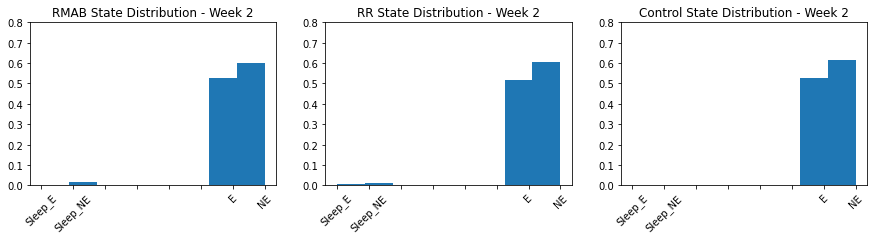




Week2
rmab
          Proportion  Count
E           0.436881   3350
NE          0.520736   3993
Sleep_E     0.018127    139
Sleep_NE    0.024257    186

RR
          Proportion  Count
E           0.430360   3300
NE          0.527256   4043
Sleep_E     0.017084    131
Sleep_NE    0.025300    194

All
    Proportion  Count
E     0.449328   3445
NE    0.550672   4222


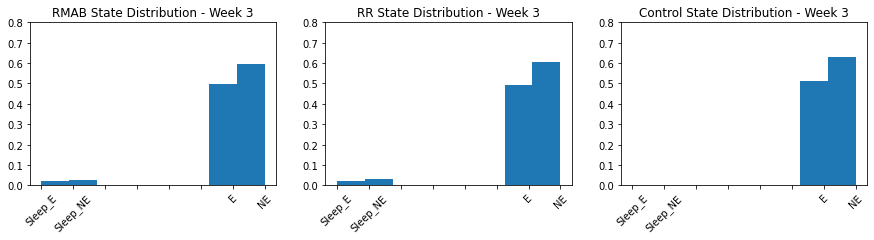




Week3
rmab
          Proportion  Count
E           0.417188   3199
NE          0.517606   3969
Sleep_E     0.029864    229
Sleep_NE    0.035342    271

RR
          Proportion  Count
E           0.419144   3214
NE          0.517084   3965
Sleep_E     0.028951    222
Sleep_NE    0.034820    267

All
    Proportion  Count
E     0.454285   3483
NE    0.545715   4184


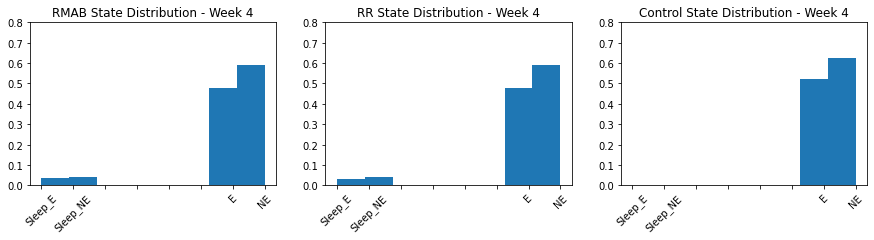




Week4
rmab
          Proportion  Count
E           0.392149   3007
NE          0.535211   4104
Sleep_E     0.038211    293
Sleep_NE    0.034429    264

RR
          Proportion  Count
E           0.395409   3032
NE          0.526343   4036
Sleep_E     0.033255    255
Sleep_NE    0.044992    345

All
    Proportion  Count
E     0.436938   3350
NE    0.563062   4317


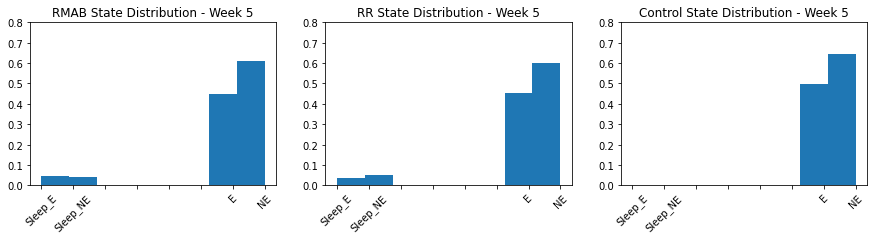




Week5
rmab
          Proportion  Count
E           0.385889   2959
NE          0.533777   4093
Sleep_E     0.050600    388
Sleep_NE    0.029734    228

RR
          Proportion  Count
E           0.402321   3085
NE          0.519431   3983
Sleep_E     0.036776    282
Sleep_NE    0.041471    318

All
    Proportion  Count
E      0.43159   3309
NE     0.56841   4358


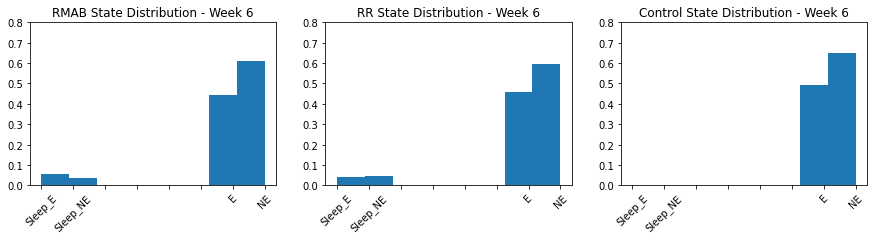




Week6
rmab
          Proportion  Count
E           0.368153   2823
NE          0.535994   4110
Sleep_E     0.058555    449
Sleep_NE    0.037298    286

RR
          Proportion  Count
E           0.390975   2998
NE          0.517736   3970
Sleep_E     0.042384    325
Sleep_NE    0.048905    375

All
    Proportion  Count
E     0.430025   3297
NE    0.569975   4370


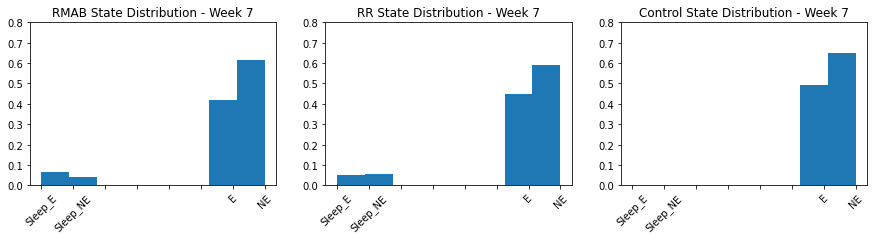




Week7
rmab
          Proportion  Count
E           0.356808   2736
NE          0.527778   4047
Sleep_E     0.072509    556
Sleep_NE    0.042906    329

RR
          Proportion  Count
E           0.380412   2917
NE          0.508738   3901
Sleep_E     0.052556    403
Sleep_NE    0.058294    447

All
    Proportion  Count
E     0.424155   3252
NE    0.575845   4415


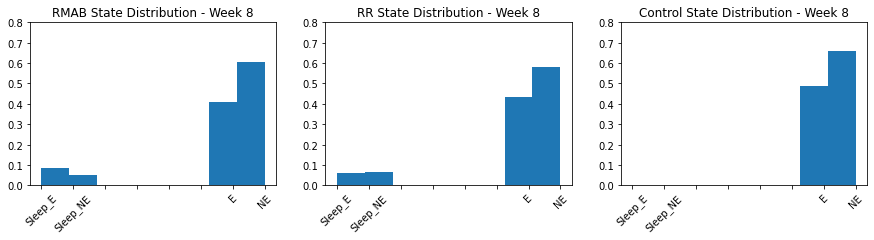




Week8
rmab
          Proportion  Count
E           0.333073   2554
NE          0.516954   3964
Sleep_E     0.095722    734
Sleep_NE    0.054251    416

RR
          Proportion  Count
E           0.365415   2802
NE          0.484611   3716
Sleep_E     0.066249    508
Sleep_NE    0.083725    642

All
    Proportion  Count
E     0.424938   3258
NE    0.575062   4409


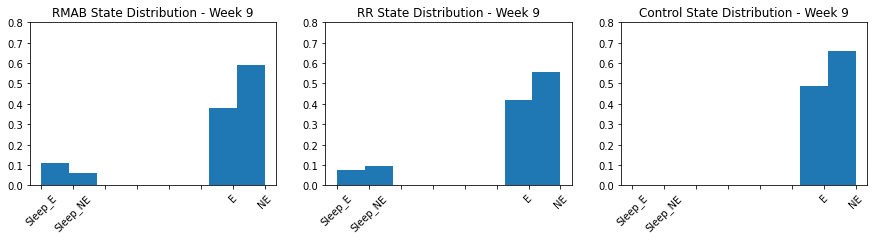




Week9
rmab
          Proportion  Count
E           0.301643   2313
NE          0.522300   4005
Sleep_E     0.128195    983
Sleep_NE    0.047861    367

RR
          Proportion  Count
E           0.353026   2707
NE          0.470918   3611
Sleep_E     0.081638    626
Sleep_NE    0.094418    724

All
    Proportion  Count
E     0.427155   3275
NE    0.572845   4392


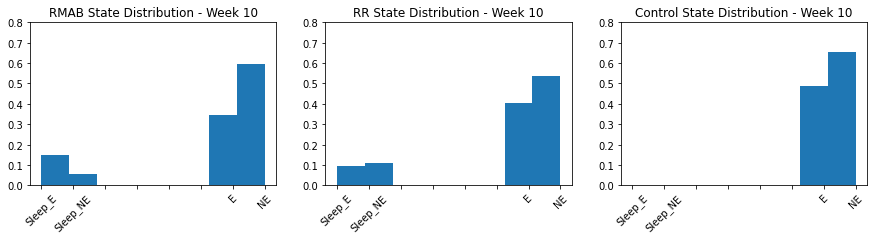




Week10
rmab
          Proportion  Count
E           0.285994   2193
NE          0.518388   3975
Sleep_E     0.135368   1038
Sleep_NE    0.060250    462

RR
          Proportion  Count
E           0.339463   2603
NE          0.464919   3565
Sleep_E     0.084637    649
Sleep_NE    0.110981    851

All
    Proportion  Count
E     0.409417   3139
NE    0.590583   4528


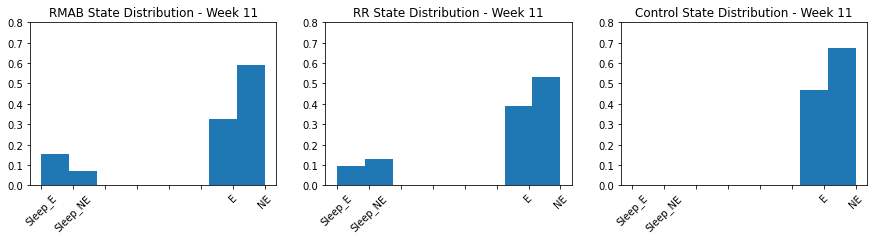

In [53]:

for i in range(T-1):
    print(f'Week{i}')
    bins=8
    plt.figure(figsize=(15, 3))
    
    
    plt.subplot(1,3,1)
    plt.hist(analysis_df[analysis_df['arm']=='rmab'][f'week{i}_state'],density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('rmab')
    print(dist_stat(analysis_df[analysis_df['arm']=='rmab'], f'week{i}_state'))
    plt.title(f'RMAB State Distribution - Week {i+1}')
    
    
    plt.subplot(1,3,2)
    plt.hist(analysis_df[analysis_df['arm']=='round_robin'][f'week{i}_state'].values, density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('\nRR')
    print(dist_stat(analysis_df[analysis_df['arm']=='round_robin'], f'week{i}_state'))
    plt.title(f'RR State Distribution - Week {i+1}')
    
    
    plt.subplot(1,3,3)
    plt.hist(analysis_df[analysis_df['arm']=='control'][f'week{i}_state'].values, density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('\nAll')
    print(dist_stat(analysis_df[analysis_df['arm']=='control'], f'week{i}_state'))
    plt.title(f'Control State Distribution - Week {i+1}')
    
    
    plt.show()
    print('\n\n')
    

    

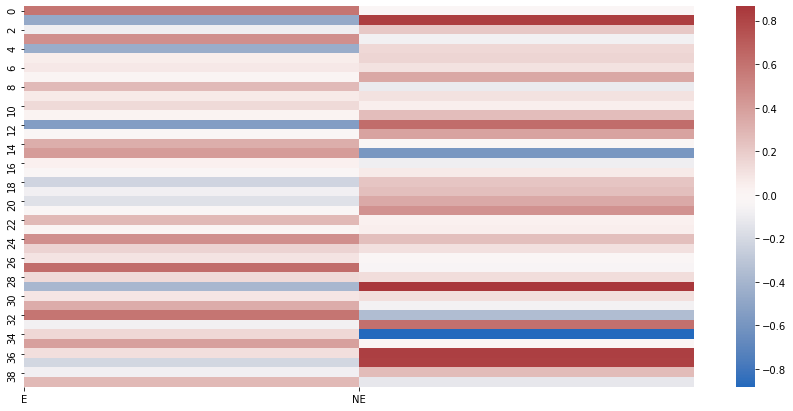

In [125]:
import seaborn as sns
plt.figure(figsize=(15, 7))
sns.heatmap(m_values[:, 6:], cmap="vlag")
plt.xticks([0,1], ['E', 'NE'])
plt.show()

In [128]:
m_values[3], m_values[27], m_values[29]

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.46517181, -0.07440186]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.63092804, -0.04057312]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.38793945,  0.86569214]))

(array([  1.,   2.,   3.,   3.,  16., 267.,  11.,   8.,   5.,   4.]),
 array([-0.8828125 , -0.70796204, -0.53311157, -0.35826111, -0.18341064,
        -0.00856018,  0.16629028,  0.34114075,  0.51599121,  0.69084167,
         0.86569214]),
 <BarContainer object of 10 artists>)

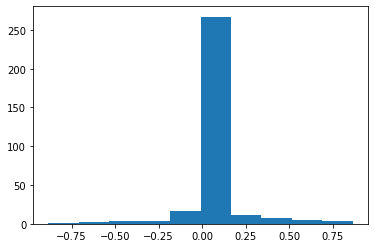

In [138]:
plt.hist(m_values.flatten(), bins=10)

In [12]:
lookup = {7:'NE', 6:'E', 0:'Sleep_E', 1:'Sleep_NE'}

def get_prob(string):
    cluster = int(string.split('-')[0])
    state = string.split('-')[1]
    if state=='E' or state=='Sleep_E':
        state = 'E'
    else:
        state = 'NE'
    prob_i = cluster_transition_probabilities.loc[cluster][f'P({state}, I, E)']
    prob_a = cluster_transition_probabilities.loc[cluster][f'P({state}, A, NE)']
    return prob_i, prob_a

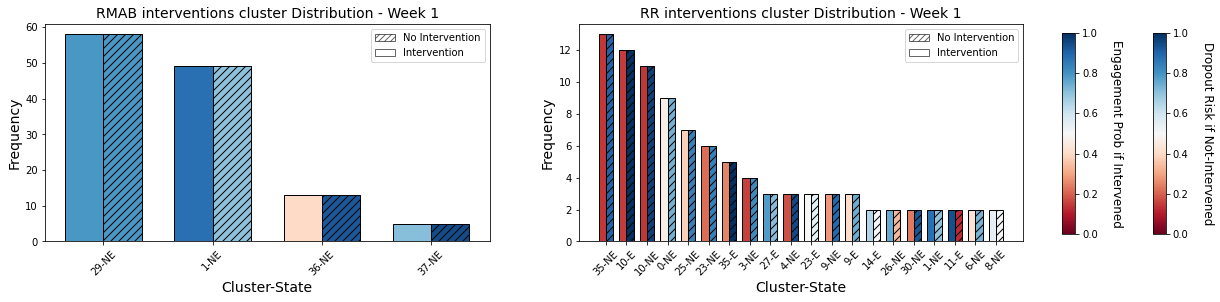

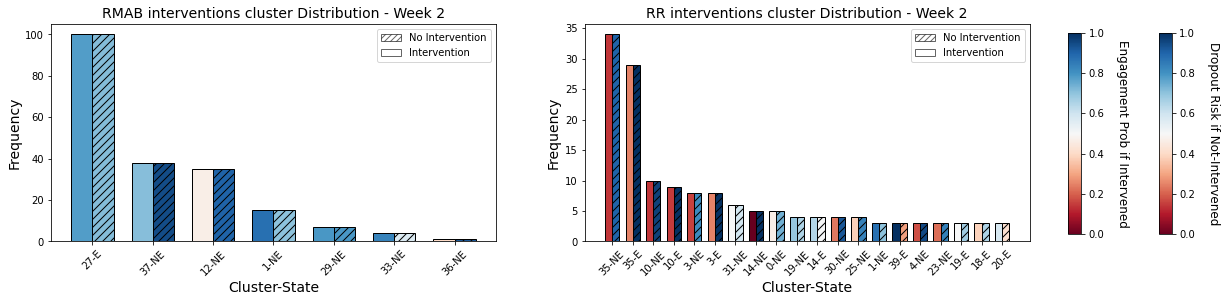

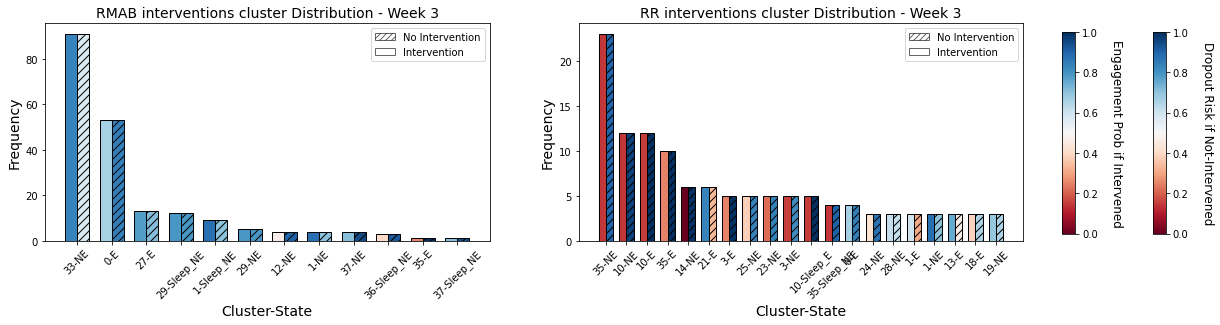

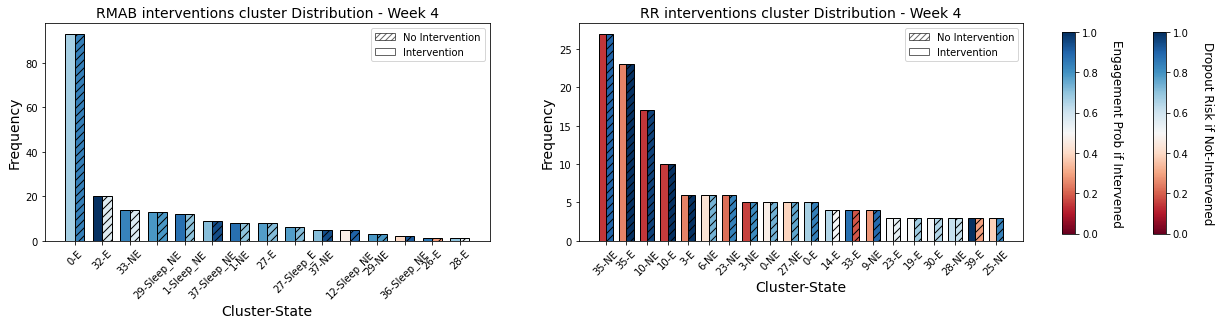

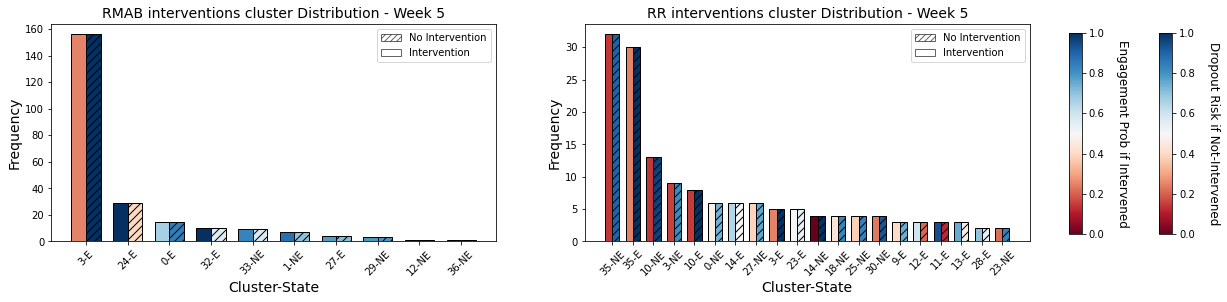

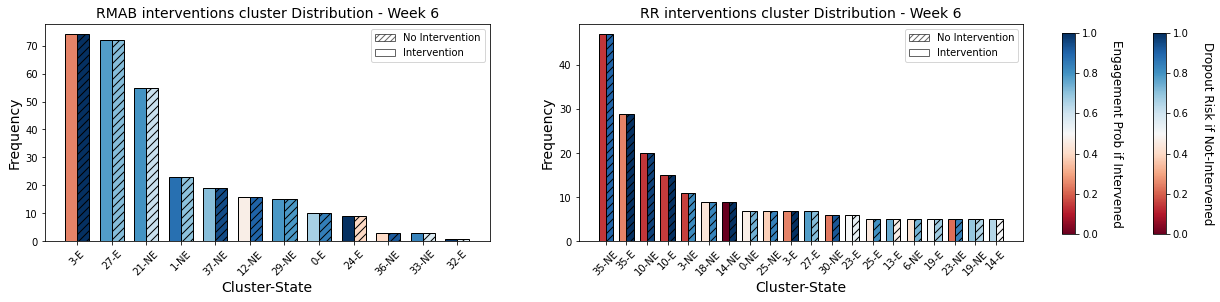

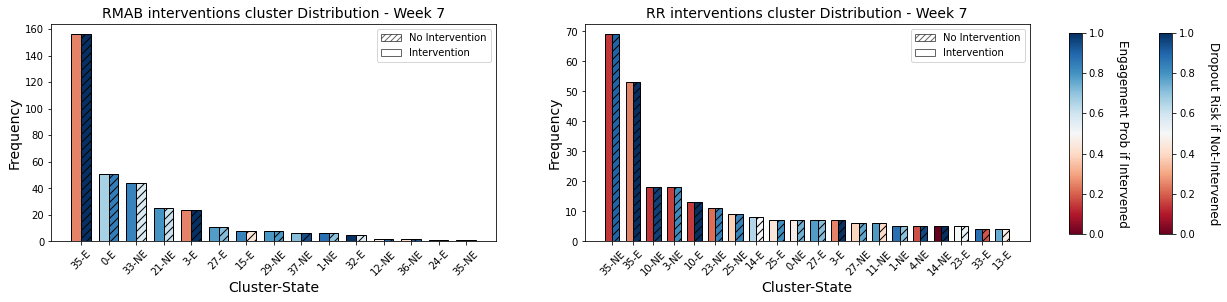

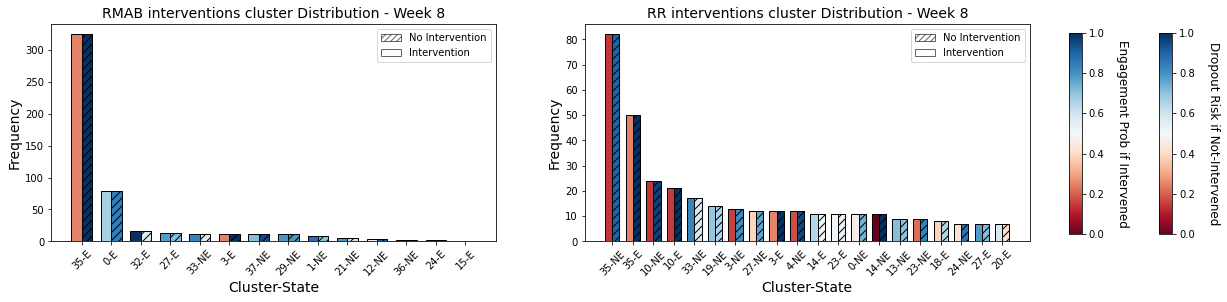

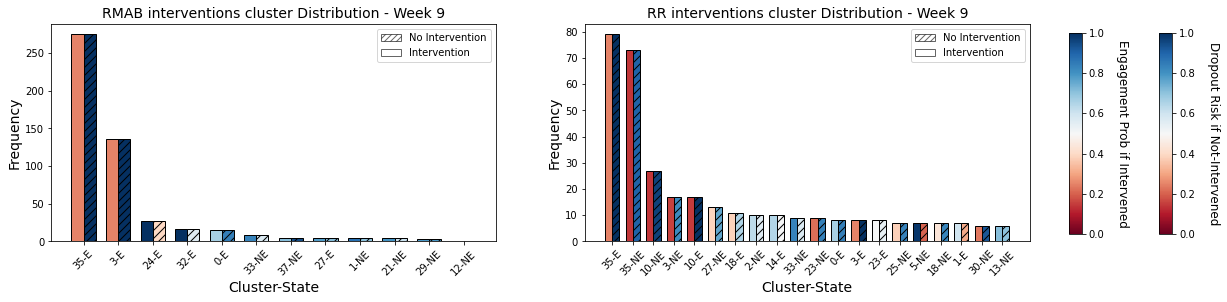

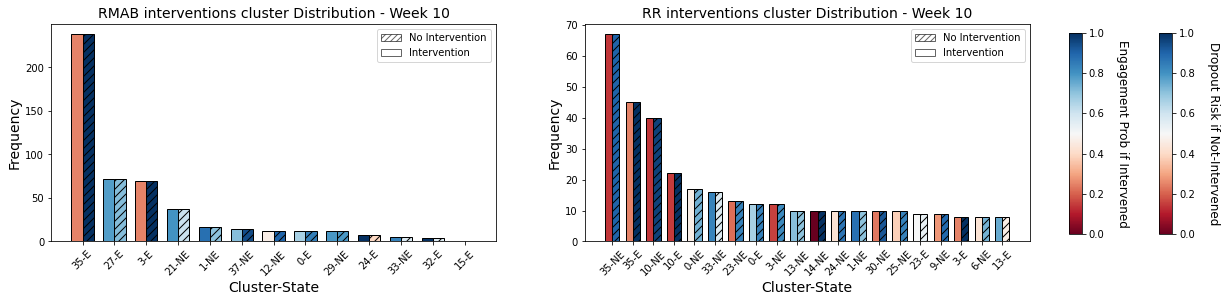

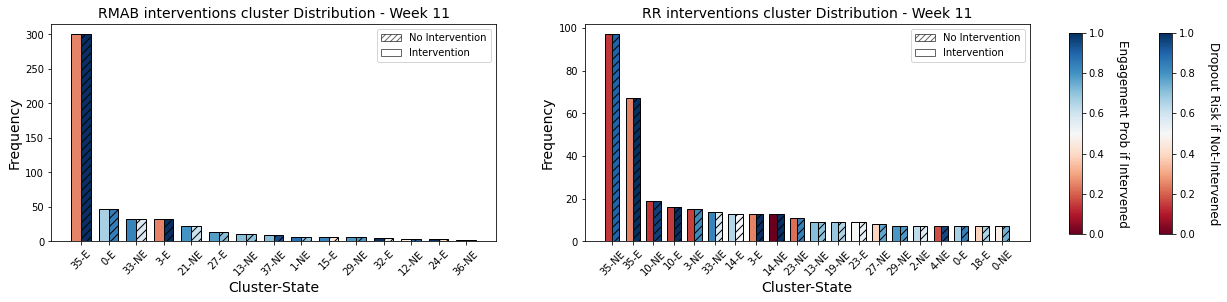

In [252]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

width = 0.35
risk_spectrum = 'RdBu'
success_spectrum = 'RdBu'
succ_cmap = plt.cm.get_cmap(success_spectrum)
risk_cmap = plt.cm.get_cmap(risk_spectrum)
T = 12
for i in range(T-1):
    plt.figure(figsize=(18, 4))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    sub = pd.merge(sub, analysis_df[['user_id', f'week{i}_state']])
    sub['cluster_state'] = sub['cluster'].astype(str)+'-'+sub[f'week{i}_state'].replace(lookup)
    
    
    plt.subplot(1,2,1)
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))-width/2, vc.values, edgecolor='black', width=width, color=colors)

    
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
    data_color_normalized = [get_prob(col)[1] for col in vc.index]
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


    circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
    circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

    plt.legend(handles = [circ1,circ2])

    plt.title(f'RMAB interventions cluster Distribution - Week {i+1}', fontsize=14)
    
    
    
    
    
    plt.subplot(1,2,2)
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))-width/2, vc.values, edgecolor='black', width=width, color=colors)

    
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
    data_color_normalized = [get_prob(col)[1] for col in vc.index]
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


    circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
    circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

    plt.legend(handles = [circ1,circ2])

    plt.title(f'RR interventions cluster Distribution - Week {i+1}', fontsize=14)
    
    fig = plt.gcf()
    fig.subplots_adjust(right=0.88)
    cbar_ax_1 = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    cbar_ax_2 = fig.add_axes([0.98, 0.15, 0.01, 0.7])

    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax_1)
    cbar.set_label('Engagement Prob if Intervened', rotation=270,labelpad=25, fontsize=12)
    
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax_2)
    cbar.set_label('Dropout Risk if Not-Intervened', rotation=270,labelpad=25, fontsize=12)
    
#     plt.tight_layout()
    
    

    

In [253]:
sub

,user_id,intervene_week,intervene_date,exp_group,registration_date,cluster,days_since_reg,week10_state,cluster_state
0,2399732,week11,2021-07-05,rmab,2021-02-18,29,137,7,29-NE
1,2396177,week11,2021-07-05,rmab,2021-02-24,29,131,7,29-NE
2,2392613,week11,2021-07-05,rmab,2021-02-23,36,132,7,36-NE
3,2395566,week11,2021-07-05,rmab,2021-02-26,1,129,7,1-NE
4,2395407,week11,2021-07-05,rmab,2021-02-26,29,129,7,29-NE
...,...,...,...,...,...,...,...,...,...
995,2395228,week11,2021-07-05,round_robin,2021-02-22,16,133,7,16-NE
996,2395195,week11,2021-07-05,round_robin,2021-02-23,35,132,7,35-NE
997,2392191,week11,2021-07-05,round_robin,2021-02-22,16,133,7,16-NE
998,2394510,week11,2021-07-05,round_robin,2021-02-23,35,132,6,35-E


## Engagaing vs Non Engagaing Effort


In [10]:
interv_df

,user_id,intervene_week,intervene_date,exp_group,registration_date,cluster,days_since_reg
0,2393699,week1,2021-04-29,rmab,2021-02-25,1,63
1,2387277,week1,2021-04-29,round_robin,2021-02-01,10,87
2,2401025,week1,2021-04-29,rmab,2021-03-03,1,57
3,2401025,week3,2021-05-12,rmab,2021-03-03,1,70
4,2401025,week4,2021-05-18,rmab,2021-03-03,1,76
...,...,...,...,...,...,...,...
7180,2395228,week11,2021-07-05,round_robin,2021-02-22,16,133
7181,2395195,week11,2021-07-05,round_robin,2021-02-23,35,132
7182,2392191,week11,2021-07-05,round_robin,2021-02-22,16,133
7183,2394510,week11,2021-07-05,round_robin,2021-02-23,35,132


2021-09-04 16:46:09,459 - DEBUG - _get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fabce0c2bb0>
2021-09-04 16:46:09,459 - DEBUG - update_ticks - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fabce0c2bb0> on colorbar
2021-09-04 16:46:09,460 - DEBUG - _add_solids - Setting pcolormesh
2021-09-04 16:46:09,581 - DEBUG - _get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fabce1fab50>
2021-09-04 16:46:09,582 - DEBUG - update_ticks - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fabce1fab50> on colorbar
2021-09-04 16:46:09,582 - DEBUG - _add_solids - Setting pcolormesh
2021-09-04 16:46:09,709 - DEBUG - _get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fabceae85b0>
2021-09-04 16:46:09,710 - DEBUG - update_ticks - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator obje

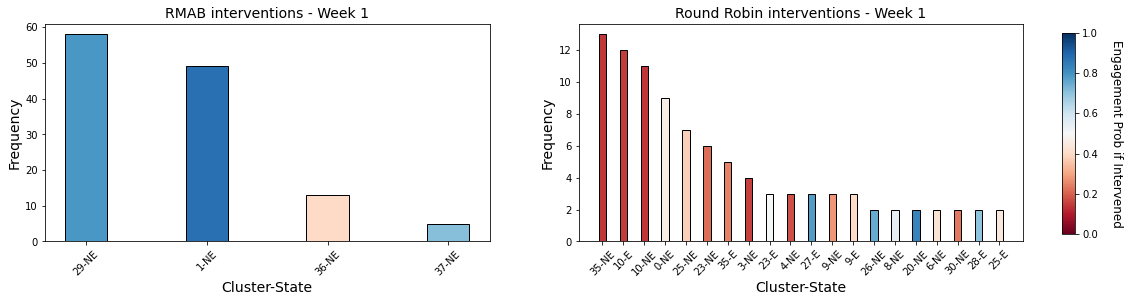

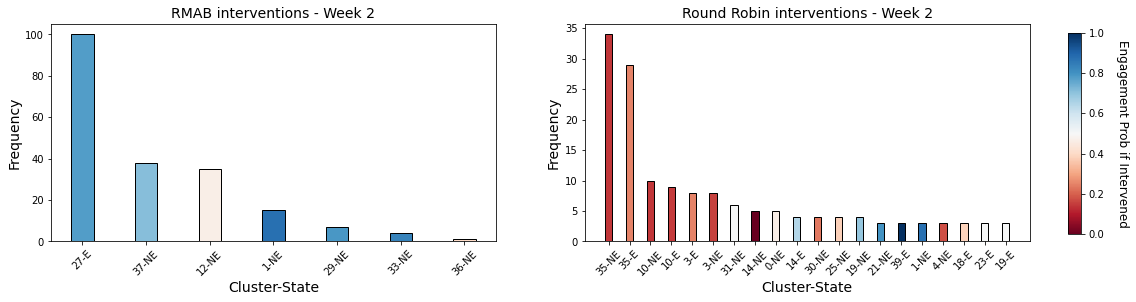

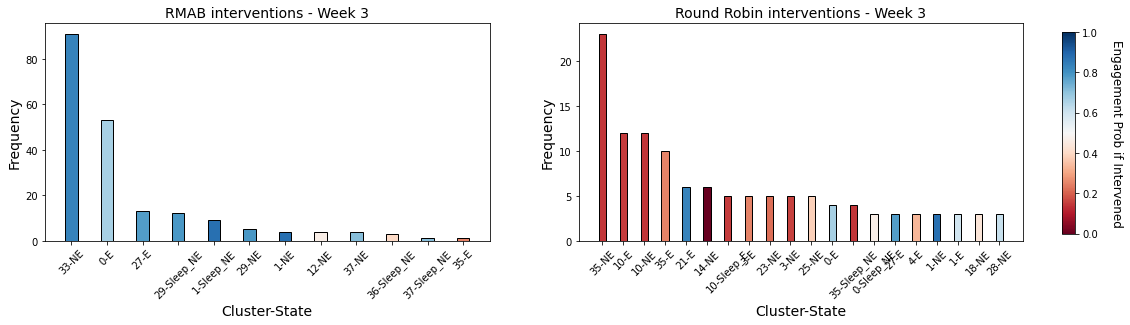

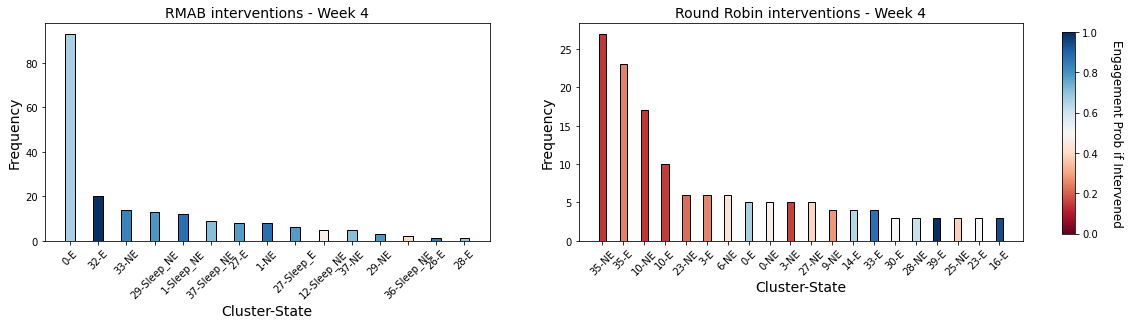

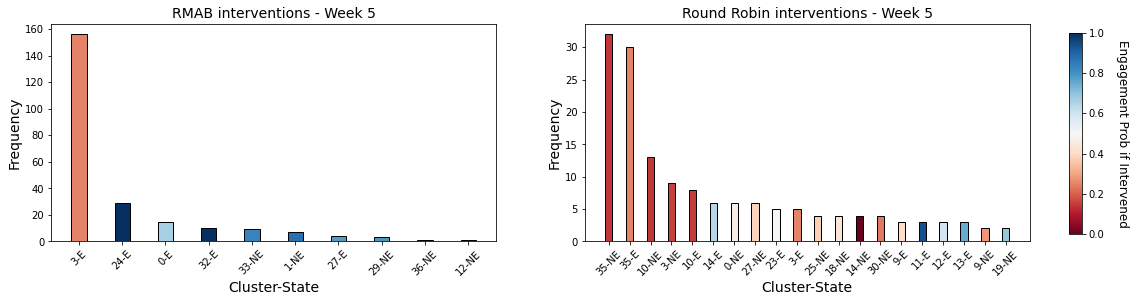

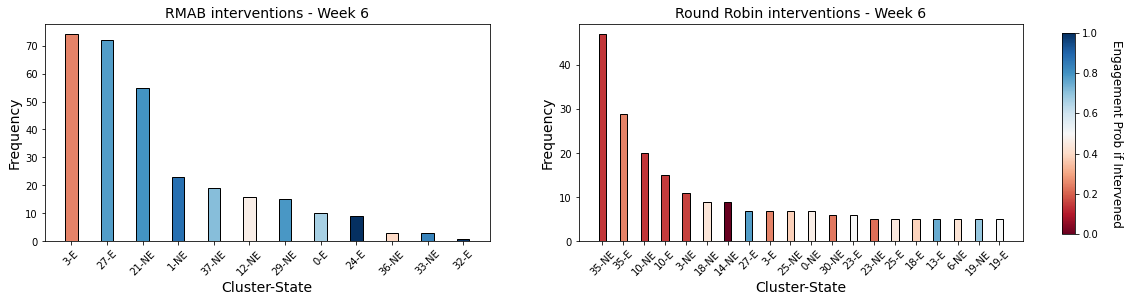

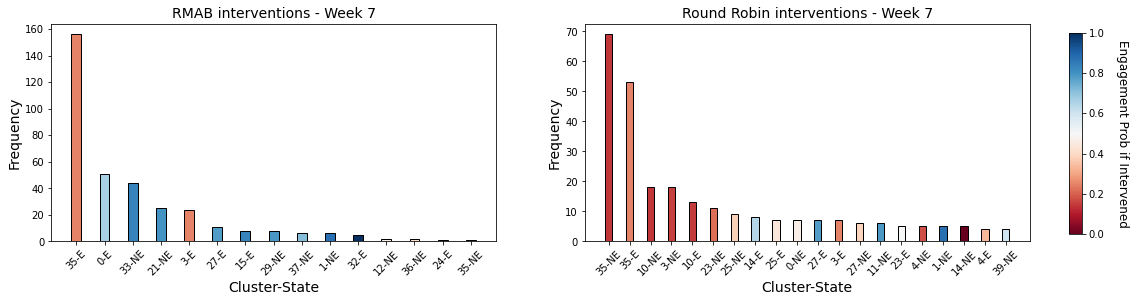

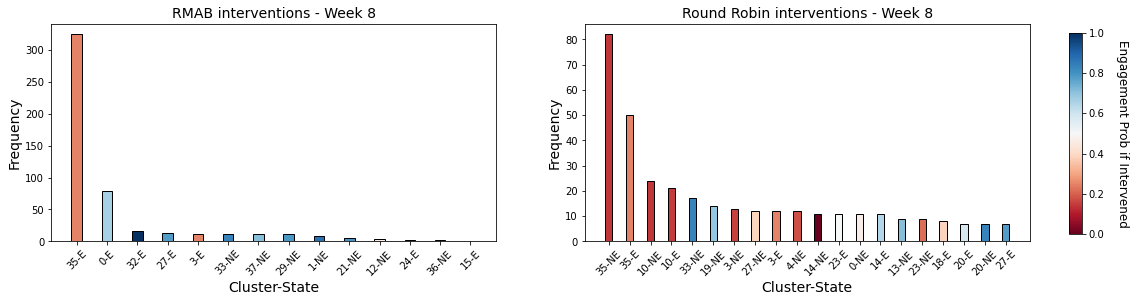

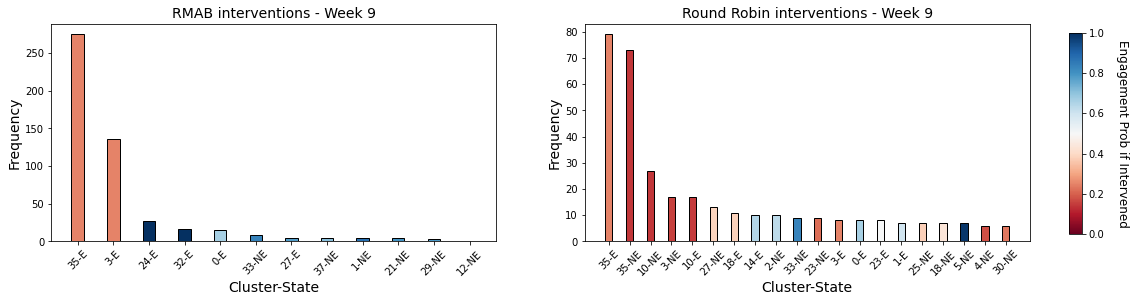

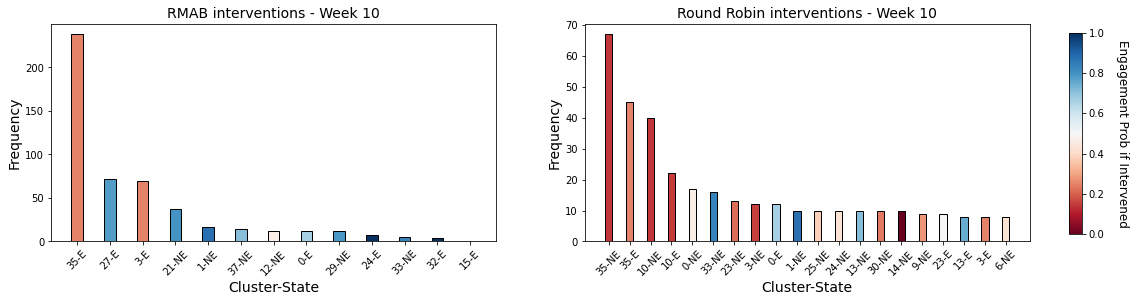

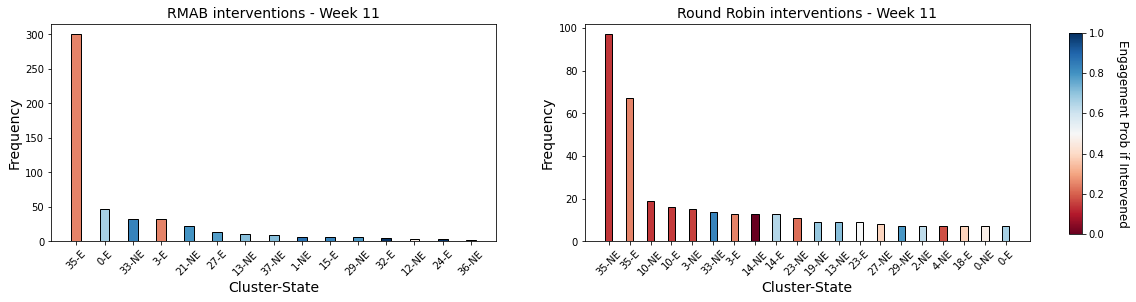

In [14]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

width = 0.35
risk_spectrum = 'RdBu'
success_spectrum = 'RdBu'
succ_cmap = plt.cm.get_cmap(success_spectrum)
risk_cmap = plt.cm.get_cmap(risk_spectrum)
T = 12
for i in range(T-1):
    plt.figure(figsize=(18, 4))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    sub = pd.merge(sub, analysis_df[['user_id', f'week{i}_state']])
    sub['cluster_state'] = sub['cluster'].astype(str)+'-'+sub[f'week{i}_state'].replace(lookup)
    
    
    plt.subplot(1,2,1)
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc)), vc.values, edgecolor='black', width=width, color=colors)

    
#     vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
#     data_color_normalized = [get_prob(col)[1] for col in vc.index]
#     colors = risk_cmap(data_color_normalized)
#     sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
#     sm.set_array([])

#     plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


#     circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
    circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

#     plt.legend(handles = [circ1,circ2])
#     plt.legend(handles = [circ2])

    plt.title(f'RMAB interventions - Week {i+1}', fontsize=14)
    
    
    
    
    
    plt.subplot(1,2,2)
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc)), vc.values, edgecolor='black', width=width, color=colors)

    
#     vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
#     data_color_normalized = [get_prob(col)[1] for col in vc.index]
#     colors = risk_cmap(data_color_normalized)
#     sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
#     sm.set_array([])

#     plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


#     circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
#     circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

#     plt.legend(handles = [circ1,circ2])

    plt.title(f'Round Robin interventions - Week {i+1}', fontsize=14)
    
    fig = plt.gcf()
    fig.subplots_adjust(right=0.88)
    cbar_ax_1 = fig.add_axes([0.91, 0.15, 0.01, 0.7])
#     cbar_ax_2 = fig.add_axes([0.98, 0.15, 0.01, 0.7])

    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax_1)
    cbar.set_label('Engagement Prob if Intervened', rotation=270,labelpad=25, fontsize=12)
    
#     colors = risk_cmap(data_color_normalized)
#     sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
#     sm.set_array([])
#     cbar = plt.colorbar(sm, cax=cbar_ax_2)
#     cbar.set_label('Dropout Risk if Not-Intervened', rotation=270,labelpad=25, fontsize=12)
    
#     plt.tight_layout()
    
    

    

In [79]:
cluster_transition_probabilities[cluster_transition_probabilities['P(NE, I, E)']<0.2]['count'].sum()/cluster_transition_probabilities['count'].sum()

0.29565832940066067

In [82]:
cluster_transition_probabilities

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.666667,0.333333,0.466667,0.533333,0.153001,0.846999,0.258012,0.741988
1,1.0,83.0,0.600000,0.400000,0.875000,0.125000,0.689132,0.310868,0.294719,0.705281
2,2.0,104.0,0.600000,0.400000,0.631579,0.368421,0.560425,0.439575,0.441054,0.558946
3,3.0,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
4,4.0,129.0,0.333333,0.666667,0.176471,0.823529,0.501182,0.498818,0.048505,0.951495
5,5.0,50.0,0.958333,0.041667,0.985655,0.014345,0.818342,0.181658,0.795455,0.204545
6,6.0,128.0,0.571429,0.428571,0.428571,0.571429,0.419136,0.580864,0.263838,0.736162
7,7.0,53.0,0.947368,0.052632,0.479162,0.520838,0.914069,0.085931,0.288961,0.711039
8,8.0,75.0,0.636364,0.363636,0.545455,0.454545,0.390496,0.609504,0.493551,0.506449
9,9.0,117.0,0.402725,0.597275,0.277778,0.722222,0.250526,0.749474,0.108681,0.891319


In [87]:
pilot_cluster_transition_prob = cluster_transition_probabilities.copy()
pilot_cluster_transition_prob['count'] = df.groupby(['cluster'])['user_id'].count().sort_index().values

In [94]:
print('non recoverable')
print(0.1, pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, I, E)']<0.1]['count'].sum()/pilot_cluster_transition_prob['count'].sum())

print(0.2, pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, I, E)']<0.2]['count'].sum()/pilot_cluster_transition_prob['count'].sum())


non recoverable
0.1 0.046211363735164976
0.2 0.48124157718558447


In [115]:
print('self correcting')
print(0.7, pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, A, E)']>0.7]['count'].sum()/pilot_cluster_transition_prob['count'].sum())
print(0.8, pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, A, E)']>0.8]['count'].sum()/pilot_cluster_transition_prob['count'].sum())
print(0.9, pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, A, E)']>0.9]['count'].sum()/pilot_cluster_transition_prob['count'].sum())



self correcting
0.7 0.03230013476503065
0.8 0.019214885014998045
0.9 0.019214885014998045


In [97]:
pilot_cluster_transition_prob[pilot_cluster_transition_prob['P(NE, A, E)']>0.7]

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
5,5.0,247,0.958333,0.041667,0.985655,0.014345,0.818342,0.181658,0.795455,0.204545
15,15.0,54,0.833333,0.166667,0.500000,0.500000,0.558678,0.441322,0.731302,0.268698
16,16.0,377,0.947368,0.052632,1.000000,0.000000,0.884824,0.115176,1.000000,0.000000
34,34.0,65,0.600000,0.400000,0.333333,0.666667,0.710720,0.289280,0.965347,0.034653


In [ ]:
non recoverable -> P(NE, I, E) < 0.1 -> 176, 0.2 -> 1253
self correcting ->

### Paper Plot

In [110]:
my_lookup = {7: 'NE', 6: 'E', 0: 'E', 1: 'NE'}
# my_lookup = {7: '\'', 6: '', 0: '', 1: '\''}

In [120]:
id_lookup = {}
id_val = 0
for i in range(40):
    for j_idx, j in enumerate(['E', 'NE']):
        id_lookup[f'{i}-{j}'] = str(i)+['', '\''][j_idx]
        id_lookup[f'{i}-{j}'] = str(i)+str(j)
        id_val+=1
# id_lookup

In [121]:
lookup = {7:'NE', 6:'E', 0:'Sleep_E', 1:'Sleep_NE'}

def get_prob(string):
    cluster = int(string.split('-')[0])
    state = string.split('-')[1]
    if state=='E' or state=='Sleep_E':
        state = 'E'
    else:
        state = 'NE'
    prob_i = cluster_transition_probabilities.loc[cluster][f'P({state}, I, E)']
    prob_a = cluster_transition_probabilities.loc[cluster][f'P({state}, A, NE)']
    return prob_i, prob_a

2021-09-09 10:42:41,092 - DEBUG - _get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fde869e86d0>
2021-09-09 10:42:41,093 - DEBUG - update_ticks - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fde869e86d0> on colorbar
2021-09-09 10:42:41,093 - DEBUG - _add_solids - Setting pcolormesh


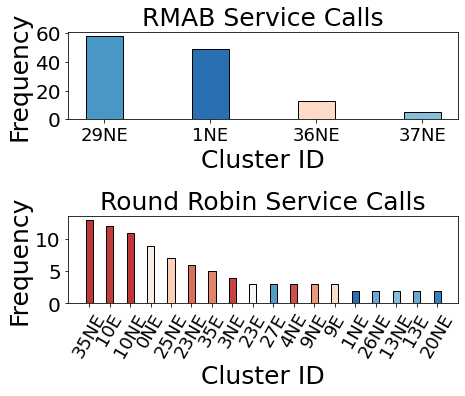

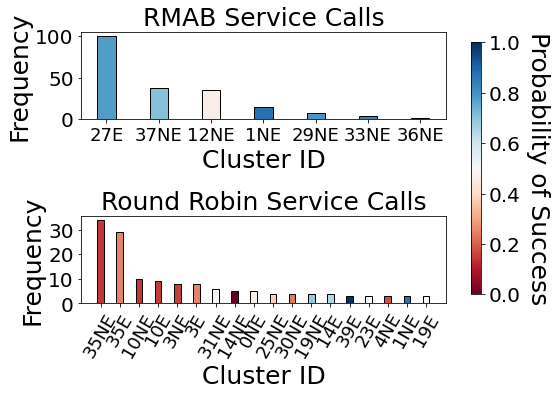

In [126]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

width = 0.35
risk_spectrum = 'RdBu'
success_spectrum = 'RdBu'
succ_cmap = plt.cm.get_cmap(success_spectrum)
risk_cmap = plt.cm.get_cmap(risk_spectrum)
T = 12
for i in range(2):
    plt.figure(figsize=(7, 5))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    sub = pd.merge(sub, analysis_df[['user_id', f'week{i}_state']])
    sub['cluster_state'] = sub['cluster'].astype(str)+'-'+sub[f'week{i}_state'].replace(my_lookup)
    
    plt.subplot(2,1,1)
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:15]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc)), vc.values, edgecolor='black', width=width, color=colors)

    plt.xticks(list(np.arange(len(vc))),
          [id_lookup[i] for i in vc.index], rotation=0, fontsize=18)
    plt.xlabel('Cluster ID', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.yticks(fontsize=20)
    plt.title(f'RMAB Service Calls', fontsize=25)
    
    
    
    
    
    plt.subplot(2,1,2)
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:18]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)

    plt.bar(np.arange(len(vc)), vc.values, edgecolor='black', width=width, color=colors)


    plt.xticks(list(np.arange(len(vc))),
          [id_lookup[i] for i in vc.index], rotation=60, fontsize=18)
    plt.xlabel('Cluster ID', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.yticks(fontsize=20)
    


    plt.title(f'Round Robin Service Calls', fontsize=25)
    
    fig = plt.gcf()
    if i==1:
        fig.subplots_adjust(right=0.85)
        cbar_ax_1 = fig.add_axes([0.9, 0.15, 0.02, 0.7])
        sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cbar_ax_1)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Probability of Success', rotation=270,labelpad=30, fontsize=25)

    plt.subplots_adjust( 
                    hspace=1.1)
    
    

    

In [129]:
id_lookup = {}
id_val = 0
for i in range(40):
    for j_idx, j in enumerate(['E', 'NE']):
        id_lookup[f'{i}-{j}'] = str(i)+['', ''][j_idx]
#         id_lookup[f'{i}-{j}'] = str(i)+str(j)
        id_val+=1

35-NE    34
35-E     29
10-NE    10
10-E      9
3-NE      8
3-E       8
31-NE     6
14-NE     5
0-NE      5
25-NE     4
30-NE     4
19-NE     4
14-E      4
39-E      3
23-E      3
4-NE      3
1-NE      3
19-E      3
Name: cluster_state, dtype: int64

2021-09-09 11:05:34,991 - DEBUG - _get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fde88adf550>
2021-09-09 11:05:34,991 - DEBUG - update_ticks - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fde88adf550> on colorbar
2021-09-09 11:05:34,992 - DEBUG - _add_solids - Setting pcolormesh


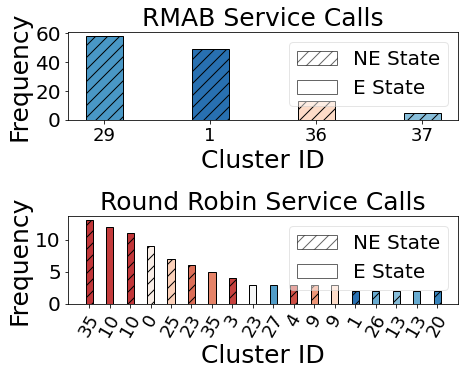

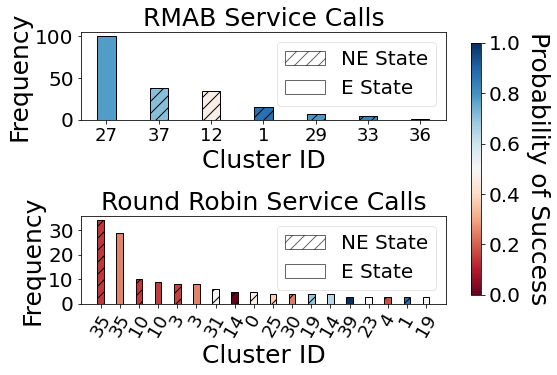

In [147]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

width = 0.35
risk_spectrum = 'RdBu'
success_spectrum = 'RdBu'
succ_cmap = plt.cm.get_cmap(success_spectrum)
risk_cmap = plt.cm.get_cmap(risk_spectrum)
T = 12
for i in range(2):
    plt.figure(figsize=(7, 5))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    sub = pd.merge(sub, analysis_df[['user_id', f'week{i}_state']])
    sub['cluster_state'] = sub['cluster'].astype(str)+'-'+sub[f'week{i}_state'].replace(my_lookup)
    
    plt.subplot(2,1,1)
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:15]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    e_mask = np.array([idx.split('-')[1]=='E' for idx in vc.index])
    
    plt.bar(np.arange(len(vc))[e_mask], vc.values[e_mask], edgecolor='black', width=width, color=colors[e_mask])
    plt.bar(np.arange(len(vc))[~e_mask], vc.values[~e_mask], edgecolor='black', hatch='//', width=width, color=colors[~e_mask])

    plt.xticks(list(np.arange(len(vc))),
          [id_lookup[i] for i in vc.index], rotation=0, fontsize=18)
    plt.xlabel('Cluster ID', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.yticks(fontsize=20)
    
    a_val = 0.6
    circ1 = mpatches.Patch( facecolor='#FFFFFF',alpha=a_val,hatch=r'//', edgecolor='black', label='NE State')
    circ2= mpatches.Patch( facecolor='#FFFFFF',alpha=a_val,hatch=' ', edgecolor='black', label='E State')
    plt.legend(handles = [circ1,circ2], fontsize=20, framealpha=0.5)
    plt.title(f'RMAB Service Calls', fontsize=25)
    
    
    
    
    
    plt.subplot(2,1,2)
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:18]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)

    e_mask = np.array([idx.split('-')[1]=='E' for idx in vc.index])
    
    plt.bar(np.arange(len(vc))[e_mask], vc.values[e_mask], edgecolor='black', width=width, color=colors[e_mask])
    plt.bar(np.arange(len(vc))[~e_mask], vc.values[~e_mask], edgecolor='black', hatch='//', width=width, color=colors[~e_mask])



    plt.xticks(list(np.arange(len(vc))),
          [id_lookup[i] for i in vc.index], rotation=60, fontsize=18)
    plt.xlabel('Cluster ID', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.yticks(fontsize=20)
    

    a_val = 0.6
    circ1 = mpatches.Patch( facecolor='#FFFFFF',alpha=a_val,hatch=r'//', edgecolor='black', label='NE State')
    circ2= mpatches.Patch( facecolor='#FFFFFF',alpha=a_val,hatch=' ', edgecolor='black', label='E State')
    plt.legend(handles = [circ1,circ2], fontsize=20, framealpha=0.5)
    plt.title(f'Round Robin Service Calls', fontsize=25)
    
    fig = plt.gcf()
    if i==1:
        fig.subplots_adjust(right=0.85)
        cbar_ax_1 = fig.add_axes([0.9, 0.15, 0.02, 0.7])
        sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cbar_ax_1)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Probability of Success', rotation=270,labelpad=30, fontsize=25)

    plt.subplots_adjust( 
                    hspace=1.1)
    
    

    

In [ ]:
#     plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    

    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


#     circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
#     circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

#     plt.legend(handles = [circ1,circ2])


In [44]:
interv_df.groupby(['intervene_week', 'exp_group'])['user_id'].count()

intervene_week  exp_group  
week1           rmab           125
                round_robin    125
week10          rmab           500
                round_robin    500
week11          rmab           500
                round_robin    500
week2           rmab           200
                round_robin    200
week3           rmab           200
                round_robin    200
week4           rmab           200
                round_robin    200
week5           rmab           235
                round_robin    200
week6           rmab           300
                round_robin    300
week7           rmab           350
                round_robin    350
week8           rmab           500
                round_robin    500
week9           rmab           500
                round_robin    500
Name: user_id, dtype: int64

In [45]:
np.mean([125, 200, 200, 200, 200, 300, 350])

225.0

In [37]:
shresth_df = pd.read_csv('/Users/vermashresth/Documents/armman-prod/mmitra-rmab/checking_weekly_kmeans_pilot_stats_40.csv')


In [38]:
merged_df = pd.merge(analysis_df[['user_id', 'cluster']], shresth_df[['user_id', 'cluster']], on='user_id')
merged_df[merged_df['cluster_x']!=merged_df['cluster_y']]

,user_id,cluster_x,cluster_y


In [40]:
lovish_df = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')


In [41]:
merged_df = pd.merge(lovish_df[['user_id', 'cluster']], shresth_df[['user_id', 'cluster']], on='user_id')
merged_df[merged_df['cluster_x']!=merged_df['cluster_y']]

,user_id,cluster_x,cluster_y


In [47]:
gargi_df = pd.read_csv('/Users/vermashresth/Downloads/checking_weekly_kmeans_pilot_stats_40 (1).csv')

In [48]:
merged_df = pd.merge(lovish_df[['user_id', 'cluster']], gargi_df[['user_id', 'cluster']], on='user_id')
merged_df[merged_df['cluster_x']!=merged_df['cluster_y']]

,user_id,cluster_x,cluster_y


In [50]:
gargi_df['cluster'].sum(), lovish_df['cluster'].sum()

(482434, 482434)

In [51]:
checking_df = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/outputs/individual_clustering/checking_weekly_kmeans_pilot_stats_40.csv')


In [52]:
merged_df = pd.merge(checking_df[['user_id', 'cluster']], gargi_df[['user_id', 'cluster']], on='user_id')
merged_df[merged_df['cluster_x']!=merged_df['cluster_y']]

,user_id,cluster_x,cluster_y
311,2398137,1,6
855,2409130,12,0
1006,2388325,33,35
5569,2397927,13,38
5781,2407347,13,9
7690,2405620,24,37
8656,2403257,4,35
10428,2392533,30,31
10528,2405593,30,35
10537,2405935,30,19


In [55]:
cluster_transition_probabilities

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.666667,0.333333,0.466667,0.533333,0.153001,0.846999,0.258012,0.741988
1,1.0,83.0,0.600000,0.400000,0.875000,0.125000,0.689132,0.310868,0.294719,0.705281
2,2.0,104.0,0.600000,0.400000,0.631579,0.368421,0.560425,0.439575,0.441054,0.558946
3,3.0,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
4,4.0,129.0,0.333333,0.666667,0.176471,0.823529,0.501182,0.498818,0.048505,0.951495
5,5.0,50.0,0.958333,0.041667,0.985655,0.014345,0.818342,0.181658,0.795455,0.204545
6,6.0,128.0,0.571429,0.428571,0.428571,0.571429,0.419136,0.580864,0.263838,0.736162
7,7.0,53.0,0.947368,0.052632,0.479162,0.520838,0.914069,0.085931,0.288961,0.711039
8,8.0,75.0,0.636364,0.363636,0.545455,0.454545,0.390496,0.609504,0.493551,0.506449
9,9.0,117.0,0.402725,0.597275,0.277778,0.722222,0.250526,0.749474,0.108681,0.891319
